In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

print("CWD =", Path.cwd())
data_path = "./data"

CWD = /home/sylph/Data_Cantatio/pablocaicedor.github.io


# Importar datos

In [22]:
df = pd.read_csv(data_path+"/Injury_Risk/Injury_Risk.csv")

# Análisis exploratorio de datos

## Metadatos

### Entradas (X):

- **EMG_Quad_RMS_mV** (mV): RMS EMG cuádriceps.
- **EMG_Ham_RMS_mV** (mV): RMS EMG isquiotibiales.
- **GRF_Vert_Norm_BW** (BW): Fuerza de reacción vertical (normalizada).
- **Omega_Shank_deg_s** (deg/s): Velocidad angular de la pierna (IMU).
- **Hip_Flex_deg** (deg): Flexión de cadera.

### Objetivos (y):

- **Knee_Flex_deg** (deg): Ángulo de flexión de rodilla (regresión).
- **Risk_Lesion** (0/1): Riesgo alto de lesión (clasificación).

## 1. Información Inicial

- Identificar tipo de variable: numérica, categórica, ordinal, binaria.
- Establecer unidad de análisis (por sujeto o por medición).
- Documentar el diccionario de variables.

In [3]:
df.head()

,Knee_Flex_deg,EMG_Quad_RMS_mV,EMG_Ham_RMS_mV,GRF_Vert_Norm_BW,Omega_Shank_deg_s,Hip_Flex_deg,Risk_Lesion
0,57.301317,0.106144,0.045175,0.340217,138.162395,18.599794,0.0
1,80.432556,0.238664,0.112961,0.321072,237.345118,30.271616,0.0
2,15.173465,0.188359,0.175860,1.178131,-199.625681,28.008046,0.0
3,33.732813,0.157691,0.149123,0.324410,99.899280,-2.305005,0.0
4,16.810117,0.055884,0.163247,0.353535,57.396787,-2.537527,1.0


In [ ]:
df["Risk_Lesion"] = df["Risk_Lesion"].astype("category")
df.info()
numregistros, numvariables = df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Knee_Flex_deg      1000 non-null   float64
 1   EMG_Quad_RMS_mV    1000 non-null   float64
 2   EMG_Ham_RMS_mV     1000 non-null   float64
 3   GRF_Vert_Norm_BW   1000 non-null   float64
 4   Omega_Shank_deg_s  1000 non-null   float64
 5   Hip_Flex_deg       1000 non-null   float64
 6   Risk_Lesion        1000 non-null   float64
dtypes: float64(7)
memory usage: 54.8 KB


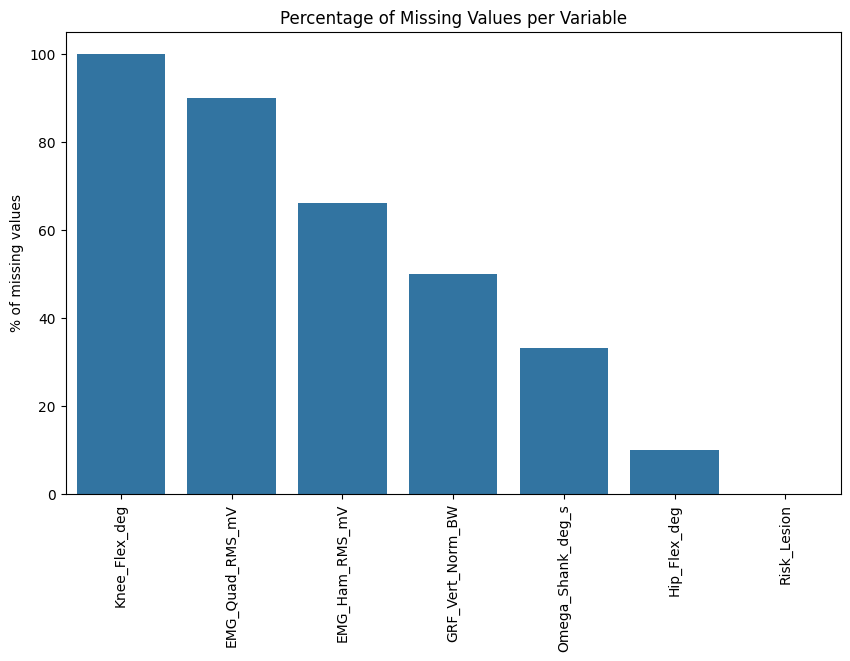

(7,)

In [ ]:
tbl_missing = df.isna().sum()
tbl_missing = 100*tbl_missing/numregistros
lbls = tbl_missing.index.values
vals = tbl_missing.values
plt.figure(figsize=(10,6))
sns.barplot(x=lbls, y=vals)
plt.xticks(rotation=90)
plt.ylabel("% of missing values")
plt.title("Percentage of Missing Values per Variable")
plt.show()
vals.shape

## 2. Calidad de los datos

- Valores faltantes: porcentaje, patrón y manejo (eliminación, imputación o modelado).
- Cardinalidad irregular: detectar columnas con un solo valor o codificación errónea.
- Outliers: aplicar criterio de Tukey o z-score (>3σ).
-Validez contextual: verificar rangos fisiológicos (e.g., knee_flex_deg ∈ [0,180]).

In [26]:
100*(df.nunique().astype(np.float64)/numregistros)

Knee_Flex_deg         77.2
EMG_Quad_RMS_mV      100.0
EMG_Ham_RMS_mV       100.0
GRF_Vert_Norm_BW     100.0
Omega_Shank_deg_s    100.0
Hip_Flex_deg         100.0
Risk_Lesion            0.2
dtype: float64

In [ ]:
df["z_score_knee_flex"]=(df["Knee_Flex_deg"]-df["Knee_Flex_deg"].mean())/df["Knee_Flex_deg"].std()
df.loc[df["z_score_knee_flex"].abs()>3, "Knee_Flex_deg"].value_counts()

Q3 = df["Knee_Flex_deg"].quantile(0.75)
Q1 = df["Knee_Flex_deg"].quantile(0.25)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df["Knee_Flex_deg"] < lower_bound) | (df["Knee_Flex_deg"] > upper_bound)]
outliers["Knee_Flex_deg"].value_counts()

Series([], Name: count, dtype: int64)

## 3. Análisis univariado

- Variables numéricas: histograma, densidad, simetría, curtosis.
- Variables categóricas: frecuencia y proporciones.
- Objetivo de regresión: distribución y normalidad de knee_flex_deg.
- Objetivo de clasificación: balance de clases en Risk_Lesion.
- Indicadores sugeridos
    - Asimetría (skew), curtosis (kurt).
    - Test de normalidad: Shapiro–Wilk o Kolmogorov–Smirnov.
    - Detección de colas largas

In [36]:
df["Risk_Lesion"].value_counts()

Risk_Lesion
1.0    506
0.0    494
Name: count, dtype: int64

## 4. Análisis bivariado

### 4.1 Regresión (knee_flex_deg)

- Correlaciones (Pearson/Spearman) entre knee_flex_deg y las variables predictoras.
- Dispersión y relación lineal/no lineal.
- Posibles transformaciones (log, sqrt, normalización z-score).

<Axes: xlabel='Knee_Flex_deg', ylabel='Hip_Flex_deg'>

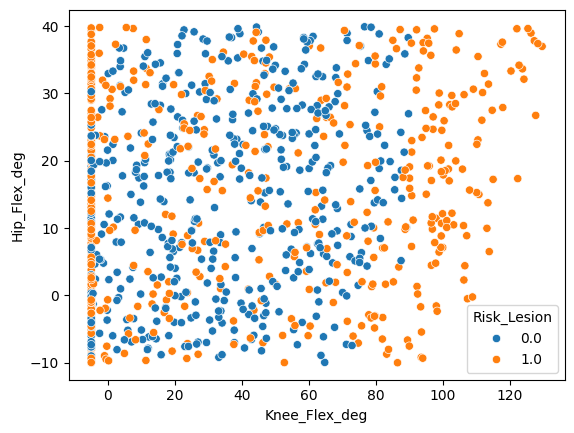

In [39]:
sns.scatterplot(data=df, x="Knee_Flex_deg", y="Hip_Flex_deg", hue="Risk_Lesion")

### 4.2 Clasificación (Risk_Lesion)

- Comparación de medias por grupo (t-test o ANOVA).
- Visualización de separación de clases: sns.pairplot(hue='Risk_Lesion').
- Matriz de correlación de variables relevantes para discriminación.

In [40]:
df.corr()

,Knee_Flex_deg,EMG_Quad_RMS_mV,EMG_Ham_RMS_mV,GRF_Vert_Norm_BW,Omega_Shank_deg_s,Hip_Flex_deg,Risk_Lesion,z_score_knee_flex
Knee_Flex_deg,1.000000,0.028383,-0.062662,0.087365,0.939718,0.177873,0.118338,1.000000
EMG_Quad_RMS_mV,0.028383,1.000000,0.029310,0.014518,-0.029424,0.034785,-0.446479,0.028383
EMG_Ham_RMS_mV,-0.062662,0.029310,1.000000,0.027262,-0.005791,0.032911,0.272992,-0.062662
GRF_Vert_Norm_BW,0.087365,0.014518,0.027262,1.000000,-0.013560,-0.008858,0.037039,0.087365
Omega_Shank_deg_s,0.939718,-0.029424,-0.005791,-0.013560,1.000000,-0.044812,0.066284,0.939718
Hip_Flex_deg,0.177873,0.034785,0.032911,-0.008858,-0.044812,1.000000,0.049999,0.177873
Risk_Lesion,0.118338,-0.446479,0.272992,0.037039,0.066284,0.049999,1.000000,0.118338
z_score_knee_flex,1.000000,0.028383,-0.062662,0.087365,0.939718,0.177873,0.118338,1.000000


## 5. Análisis multivariado

- Reducción de dimensionalidad: PCA, t-SNE, o UMAP (para inspección visual).
- Evaluación de colinealidad: VIF > 5 sugiere eliminar variables redundantes.
- Mapeo estructural: identificar clústeres naturales y relaciones no lineales.

## 6. Preparación del ABT (Analytical Base Table)

- Eliminar variables con >60% de valores nulos.
- Codificar variables categóricas (one-hot o label encoding).
- Escalar numéricas (StandardScaler o MinMaxScaler).
- Dividir entre train / test sin fuga de información.

## 7. EDA orientado al modelado

- Para regresión: identificar relaciones no lineales → explorar transformaciones de knee_flex_deg.
- Para clasificación: verificar separabilidad y métricas de desequilibrio (balanced_accuracy, AUC).

# 8. Descenso de gradiente